In [1]:
import numpy as np
import gzip, pickle
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from time import sleep

C:\Users\test\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# x = np.array([
#     [15, 1, 16],
#     [15, 2, 8],
#     [6, 0.064 , 6],
#     [7, 0.128 , 6],
#     [14 , 1, 4],
#     [6,0.032 , 3],
#     [14, 1.250, 8],
#     [16, 1, 8],
#     [5, 0.008, 2],
#     [5, 0.016, 2],
#     [14, 0.5, 8],
#     [14, 1, 12],
#     [8, 0.256 , 6], 
#     [6, 0.128, 6],
#     [16 , 0.5, 4],
#     [6, 0.004, 4],
#     [5, 0.016, 4],
#     [13, 1, 4],
#     [6, 0.032, 2],
#     [7, 0.016, 4]
    
# ])

In [3]:
# y = np.array([
#     [1 ,0],
#     [1 ,0],
#     [0 ,1],
#     [0 ,1],
#     [1 ,0],
#     [0 ,1],
#     [1 ,0],
#     [1 ,0],
#     [0 ,1],
#     [0 ,1],
#     [1 ,0],
#     [1 ,0],
#     [0 ,1],
#     [0 ,1],
#     [1 ,0],
#     [0 ,1],
#     [0 ,1],
#     [1 ,0], 
#     [0 ,1],
#     [0 ,1],
# ])

In [3]:
DATA_PATH = 'mnist.pkl.gz'

with gzip.open(DATA_PATH, 'rb') as f:
    (x, y), (x_valid, y_valid), (x_test,  y_test) = pickle.load(f, encoding='latin1')
y = to_categorical(y)
y_test= to_categorical(y_test)

# x = x / 255
# x_test = x_test/255
x_test = x[:2000]
y_test = y[:2000]
x = x[2000:]
y = y[2000:]

In [4]:
y_test.shape

(2000, 10)

In [5]:
mem = {}
mem ['m'] = len(x)
mem ['n0'] = len(x[0])
mem ['n1'] = 512
mem ['n2'] = 515
mem ['n3'] = 256
mem ['n4'] = 128
mem ['n5'] = len(y[0])
mem ['l'] = 5

mem['w1'] = np.random.randn(mem['n0'] ,mem['n1'])#*np.square(2/n0)
mem['w2'] = np.random.randn(mem['n1'] ,mem['n2'])#*np.square(2/n1)
mem['w3'] = np.random.randn(mem['n2'] ,mem['n3'])#*np.square(2/n2)
mem['w4'] = np.random.randn(mem['n3'] ,mem['n4'])#*np.square(2/n3)
mem['w5'] = np.random.randn(mem['n4'] ,mem['n5'])#*np.square(2/n4)

mem['b1'] = np.zeros((1,mem['n1']))
mem['b2'] = np.zeros((1,mem['n2']))
mem['b3'] = np.zeros((1,mem['n3']))
mem['b4'] = np.zeros((1,mem['n4']))
mem['b5'] = np.zeros((1,mem['n5']))

In [6]:
def forward(data = x):
    global mem
    
    z1 = (data @ mem['w1'])+mem['b1']
    a1 = 1 / (1+np.exp(-z1))
    mem['a1'] = a1

    z2 = (a1 @ mem['w2'])+mem['b2']
    a2 = 1 / (1+np.exp(-z2))
    mem['a2'] = a2

    z3 = (a2 @ mem['w3'])+mem['b3']
    a3 = 1 / (1+np.exp(-z3))
    mem['a3'] = a3
    
    z4 = (a3 @ mem['w4'])+mem['b4']
    a4 = 1 / (1+np.exp(-z4))
    mem['a4'] = a4
    
    z5 = (a4 @ mem['w5'])+mem['b5']
    a5 = 1 / (1+np.exp(-z5))
    mem['a5'] = a5
    
    return a5

In [7]:
def loss(data =x , label = y):
    last_a = forward(data)
    size = len(data)
    return np.sum((1-label)*np.log(1-last_a) + label*np.log(last_a))/(-size)

In [8]:
loss()

42.44395177664761

In [9]:
def gradiant(data = x, label = y, dropout=False):
    global mem
    
    if(dropout):
        backup = (mem['w1'],mem['w2'],mem['w3'],mem['w4'],mem['w5'])
        mem['w1'] = (mem['w1'] * (np.random.rand(mem['w1'].shape[0] ,mem['w1'].shape[1])>0.2))/0.8
        mem['w2'] = (mem['w2'] * (np.random.rand(mem['w2'].shape[0] ,mem['w2'].shape[1])>0.1))/1
        mem['w3'] = (mem['w3'] * (np.random.rand(mem['w3'].shape[0] ,mem['w3'].shape[1])>0.2))/0.8
        mem['w4'] = (mem['w4'] * (np.random.rand(mem['w4'].shape[0] ,mem['w4'].shape[1])>0.1))/0.9
        mem['w5'] = (mem['w5'] * (np.random.rand(mem['w5'].shape[0] ,mem['w5'].shape[1])>0.00))/1

    forward(data)
    size = len(data)

    da5 = mem['a5'] - label
    mem['dw5'] = (mem['a4'].T @ da5)/size
    mem['db5'] = np.sum(da5, axis=0,keepdims=True)/size
    
    da4 = (da5 @ mem['w5'].T) * (mem['a4']-np.power(mem['a4'],2))
    mem['dw4'] = (mem['a3'].T @ da4)/size
    mem['db4'] = np.sum(da4, axis=0,keepdims=True)/size
    
    da3 = (da4 @ mem['w4'].T) * (mem['a3']-np.power(mem['a3'],2))
    mem['dw3'] = (mem['a2'].T @ da3)/size
    mem['db3'] = np.sum(da3, axis=0,keepdims=True)/size

    da2 = (da3 @ mem['w3'].T) * (mem['a2']-np.power(mem['a2'],2))
    mem['dw2'] = (mem['a1'].T @ da2)/size
    mem['db2'] = np.sum(da2, axis=0,keepdims=True)/size
    
    da1 = (da2 @ mem['w2'].T) * (mem['a1']-np.power(mem['a1'],2))
    mem['dw1'] = (data.T @ da1)/size
    mem['db1'] = np.sum(da1, axis=0,keepdims=True)/size
    
    if (dropout):
        mem['w1'] = backup[0]
        mem['w2'] = backup[1]
        mem['w3'] = backup[2]
        mem['w4'] = backup[3]
        mem['w5'] = backup[4]

In [10]:
#checking derivativs : value most be less than [0.0001]
gradiant()
first_loss__ = mem['dw5'].sum()/(mem['dw5'].shape[1]*mem['dw5'].shape[0])
a____1 = loss() 
mem['w5'] = mem['w5'] + 0.0000001
a____2 = loss()
sec__loss__ = (a____2 - a____1)/(0.0000001*mem['dw5'].shape[1]*mem['dw5'].shape[0])
(first_loss__ - sec__loss__)

3.6315317174795414e-06

In [11]:
def score(train = [x,y], test= [x_test, y_test]): 
    
    test_score = 0
    a = forward(data= test[0])
    a[a>0.5]= 1
    a[a<0.5]= 0
    for i in range(len(a)):
        if np.argmax(a[i]) == np.argmax(test[1][i]):
            test_score+=1
    test_score = (test_score/len(a))*100
    
    
    train_score = 0 
    a = forward(data= train[0])
    a[a>0.5]= 1
    a[a<0.5]= 0
    for i in range(len(a)):
        if np.argmax(a[i]) == np.argmax(train[1][i]):
            train_score+=1
    train_score = (train_score/len(a))*100
    
    return train_score ,test_score 


In [12]:
def batch_split(batch_size = 128 ,data =x ,label = y):
    batch_count =  int(x.shape[0]/batch_size)
    data2 = data[:batch_count*batch_size]
    if(x.shape[0]/batch_size != batch_count):
        a= [data[batch_count*batch_size:]]
        b= [label[batch_count*batch_size:]]
    else: a,b = [],[]
    
    data2 = np.array_split(data2 , batch_count) + a
    label2 = label[:batch_count*batch_size]
    label2 = np.array_split(label2 , batch_count) + b
    return data2 , label2


In [13]:
def backward_gradient_descent(a= 0.01 , data = x, label= y, dropout=False):
    global mem
    gradiant(data, label, dropout=dropout)
    
    new_w5 = mem['w5'] - mem['dw5']*a
    new_b5 = mem['b5'] - mem['db5']*a
    
    new_w4 = mem['w4'] - mem['dw4']*a
    new_b4 = mem['b4'] - mem['db4']*a
    
    new_w3 = mem['w3'] - mem['dw3']*a
    new_b3 = mem['b3'] - mem['db3']*a
    
    new_w2 = mem['w2'] - mem['dw2']*a
    new_b2 = mem['b2'] - mem['db2']*a
    
    new_w1 = mem['w1'] - mem['dw1']*a
    new_b1 = mem['b1'] - mem['db1']*a
    
    mem['w5'] ,mem['b5'] = new_w5 ,new_b5
    mem['w4'] ,mem['b4'] = new_w4 ,new_b4
    mem['w3'] ,mem['b3'] = new_w3 ,new_b3
    mem['w2'] ,mem['b2'] = new_w2 ,new_b2
    mem['w1'] ,mem['b1'] = new_w1 ,new_b1
    
def gradient_descent(data = x , label= y ,epoch=1, batch_size=64, dropout=False, alpha= 0.1):
    for j in range(epoch):
        batchs = batch_split(batch_size= batch_size , data= data, label = label)
        for i in tqdm(range(len(batchs[0]))):
            a = backward_gradient_descent(a= alpha , data = batchs[0][i], label= batchs[1][i], dropout=dropout)
        print("ephoc:", j+1, ' loss:', loss(data = batchs[0][i], label= batchs[1][i]),'accr:' ,score())
        
    

In [14]:
def backward_momentum (a = 0.01 ,betha = 0.9 ,data = x ,label= y ,dropout=False):
    global mem
    gradiant(data, label, dropout=dropout)
    
    v_w5_t = (betha * mem['prev_v_w5'] + (1-betha)*mem['dw5'])/(1-betha**mem['t'])
    v_b5_t = (betha * mem['prev_v_b5'] + (1-betha)*mem['db5'])
    new_w5 = mem['w5'] - v_w5_t*a
    new_b5 = mem['b5'] - v_b5_t*a
    mem['prev_v_w5'] , mem['prev_v_b5'] = v_w5_t ,v_b5_t
    
    v_w4_t = (betha * mem['prev_v_w4'] + (1-betha)*mem['dw4'])/(1-betha**mem['t'])
    v_b4_t = (betha * mem['prev_v_b4'] + (1-betha)*mem['db4'])
    new_w4 = mem['w4'] - v_w4_t*a
    new_b4 = mem['b4'] - v_b4_t*a
    mem['prev_v_w4'] , mem['prev_v_b4'] = v_w4_t ,v_b4_t
    
    v_w3_t = (betha * mem['prev_v_w3'] + (1-betha)*mem['dw3'])/(1-betha**mem['t'])
    v_b3_t = (betha * mem['prev_v_b3'] + (1-betha)*mem['db3'])
    new_w3 = mem['w3'] - v_w3_t*a
    new_b3 = mem['b3'] - v_b3_t*a
    mem['prev_v_w3'] , mem['prev_v_b3'] = v_w3_t ,v_b3_t
    
    v_w2_t = (betha * mem['prev_v_w2'] + (1-betha)*mem['dw2'])/(1-betha**mem['t'])
    v_b2_t = (betha * mem['prev_v_b2'] + (1-betha)*mem['db2'])
    new_w2 = mem['w2'] - v_w2_t*a
    new_b2 = mem['b2'] - v_b2_t*a
    mem['prev_v_w2'] , mem['prev_v_b2'] = v_w2_t ,v_b2_t
    
    v_w1_t = (betha * mem['prev_v_w1'] + (1-betha)*mem['dw1'])/(1-betha**mem['t'])
    v_b1_t = (betha * mem['prev_v_b1'] + (1-betha)*mem['db1'])
    new_w1 = mem['w1'] - v_w1_t*a
    new_b1 = mem['b1'] - v_b1_t*a
    mem['prev_v_w1'] , mem['prev_v_b1'] = v_w1_t ,v_b1_t
    
    mem['t'] = mem['t']+ 1
    
    mem['w5'] ,mem['b5'] = new_w5 ,new_b5
    mem['w4'] ,mem['b4'] = new_w4 ,new_b4
    mem['w3'] ,mem['b3'] = new_w3 ,new_b3
    mem['w2'] ,mem['b2'] = new_w2 ,new_b2
    mem['w1'] ,mem['b1'] = new_w1 ,new_b1
    
def momentum(data = x , label= y ,epoch=1, batch_size=64, dropout=False, alpha= 0.1, betha= 0.9):
    global mem
    
    mem['prev_v_w1'], mem['prev_v_w2'], mem['prev_v_w3'], mem['prev_v_w4'], mem['prev_v_w5'] = 0,0,0,0,0
    mem['prev_v_b1'], mem['prev_v_b2'], mem['prev_v_b3'], mem['prev_v_b4'], mem['prev_v_b5'] = 0,0,0,0,0
    mem['t'] = 20
    
    for j in range(epoch):
        batchs = batch_split(batch_size= batch_size , data= data, label = label)
        for i in tqdm(range(len(batchs[0]))):
            a = backward_momentum(a= alpha , data = batchs[0][i], label= batchs[1][i], dropout=dropout, betha = betha)
        print("ephoc:", j+1, ' loss:', loss(data = batchs[0][i], label= batchs[1][i]),'accr:' ,score())
    

In [15]:
def backward_RMSprop (a = 0.01 ,betha = 0.99 ,data = x ,label= y ,dropout=False,eps= 10e-9):
    global mem
    gradiant(data, label, dropout=dropout)
    
    s_w5_t = (betha * mem['prev_s_w5'] + (1-betha)*np.square(mem['dw5']))/(1-betha**mem['t'])
    s_b5_t = (betha * mem['prev_s_b5'] + (1-betha)*np.square(mem['db5']))
    new_w5 = mem['w5'] - (mem['dw5']*a)/(np.sqrt(s_w5_t)+eps)
    new_b5 = mem['b5'] - (mem['db5']*a)/(np.sqrt(s_b5_t)+eps)
    mem['prev_s_w5'] , mem['prev_s_b5'] = s_w5_t ,s_b5_t
    
    s_w4_t = (betha * mem['prev_s_w4'] + (1-betha)*np.square(mem['dw4']))/(1-betha**mem['t'])
    s_b4_t = (betha * mem['prev_s_b4'] + (1-betha)*np.square(mem['db4']))
    new_w4 = mem['w4'] - (mem['dw4']*a)/(np.sqrt(s_w4_t)+eps)
    new_b4 = mem['b4'] - (mem['db4']*a)/(np.sqrt(s_b4_t)+eps)
    mem['prev_s_w4'] , mem['prev_s_b4'] = s_w4_t ,s_b4_t
    
    s_w3_t = (betha * mem['prev_s_w3'] + (1-betha)*np.square(mem['dw3']))/(1-betha**mem['t'])
    s_b3_t = (betha * mem['prev_s_b3'] + (1-betha)*np.square(mem['db3']))
    new_w3 = mem['w3'] - (mem['dw3']*a)/(np.sqrt(s_w3_t)+eps)
    new_b3 = mem['b3'] - (mem['db3']*a)/(np.sqrt(s_b3_t)+eps)
    mem['prev_s_w3'] , mem['prev_s_b3'] = s_w3_t ,s_b3_t
    
    s_w2_t = (betha * mem['prev_s_w2'] + (1-betha)*np.square(mem['dw2']))/(1-betha**mem['t'])
    s_b2_t = (betha * mem['prev_s_b2'] + (1-betha)*np.square(mem['db2']))
    new_w2 = mem['w2'] - (mem['dw2']*a)/(np.sqrt(s_w2_t)+eps)
    new_b2 = mem['b2'] - (mem['db2']*a)/(np.sqrt(s_b2_t)+eps)
    mem['prev_s_w2'] , mem['prev_s_b2'] = s_w2_t ,s_b2_t

    s_w1_t = (betha * mem['prev_s_w1'] + (1-betha)*np.square(mem['dw1']))/(1-betha**mem['t'])
    s_b1_t = (betha * mem['prev_s_b1'] + (1-betha)*np.square(mem['db1']))
    new_w1 = mem['w1'] - (mem['dw1']*a)/(np.sqrt(s_w1_t)+eps)
    new_b1 = mem['b1'] - (mem['db1']*a)/(np.sqrt(s_b1_t)+eps)
    mem['prev_s_w1'] , mem['prev_s_b1'] = s_w1_t ,s_b1_t
    
    mem['t'] = mem['t']+ 1
    
    mem['w5'] ,mem['b5'] = new_w5 ,new_b5
    mem['w4'] ,mem['b4'] = new_w4 ,new_b4
    mem['w3'] ,mem['b3'] = new_w3 ,new_b3
    mem['w2'] ,mem['b2'] = new_w2 ,new_b2
    mem['w1'] ,mem['b1'] = new_w1 ,new_b1
    
def RMSprop(data = x , label= y ,epoch=1, batch_size=64, dropout=False, alpha= 0.1, betha= 0.99):
    global mem
    
    mem['prev_v_w1'], mem['prev_v_w2'], mem['prev_v_w3'], mem['prev_v_w4'], mem['prev_v_w5'] = 0,0,0,0,0
    mem['prev_v_b1'], mem['prev_v_b2'], mem['prev_v_b3'], mem['prev_v_b4'], mem['prev_v_b5'] = 0,0,0,0,0
    mem['prev_s_w1'], mem['prev_s_w2'], mem['prev_s_w3'], mem['prev_s_w4'], mem['prev_s_w5'] = 0,0,0,0,0
    mem['prev_s_b1'], mem['prev_s_b2'], mem['prev_s_b3'], mem['prev_s_b4'], mem['prev_s_b5'] = 0,0,0,0,0
    mem['t'] = 500
    
    for j in range(epoch):
        batchs = batch_split(batch_size= batch_size , data= data, label = label)
        for i in tqdm(range(len(batchs[0]))):
            a = backward_RMSprop(a= alpha , data = batchs[0][i], label= batchs[1][i], dropout=dropout, betha = betha)
        print("ephoc:", j+1, ' loss:', loss(data = batchs[0][i], label= batchs[1][i]),'accr:' ,score())

In [16]:
def backward_adam (a = 0.01 ,betha1 = 0.9, betha2=0.99,eps=10e-09,data = x ,label= y ,dropout=False ):
    global mem
    gradiant(data, label, dropout=dropout)
    
    v_w5_t = (betha1 * mem['prev_v_w5'] + (1-betha1)*mem['dw5'])/(1-betha1**mem['t'])
    v_b5_t = (betha1 * mem['prev_v_b5'] + (1-betha1)*mem['db5'])
    s_w5_t = (betha2 * mem['prev_s_w5'] + (1-betha2)*np.square(mem['dw5']))/(1-betha2**mem['t'])
    s_b5_t = (betha2 * mem['prev_s_b5'] + (1-betha2)*np.square(mem['db5']))
    new_w5 = mem['w5'] - (v_w5_t*a)/(np.sqrt(s_w5_t)+eps)
    new_b5 = mem['b5'] - (v_b5_t*a)/(np.sqrt(s_b5_t)+eps)
    mem['prev_s_w5'] , mem['prev_s_b5'] = s_w5_t ,s_b5_t
    mem['prev_v_w5'] , mem['prev_v_b5'] = v_w5_t ,v_b5_t
    
    v_w4_t = (betha1 * mem['prev_v_w4'] + (1-betha1)*mem['dw4'])/(1-betha1**mem['t'])
    v_b4_t = (betha1 * mem['prev_v_b4'] + (1-betha1)*mem['db4'])
    s_w4_t = (betha2 * mem['prev_s_w4'] + (1-betha2)*np.square(mem['dw4']))/(1-betha2**mem['t'])
    s_b4_t = (betha2 * mem['prev_s_b4'] + (1-betha2)*np.square(mem['db4']))
    new_w4 = mem['w4'] - (v_w4_t*a)/(np.sqrt(s_w4_t)+eps)
    new_b4 = mem['b4'] - (v_b4_t*a)/(np.sqrt(s_b4_t)+eps)
    mem['prev_s_w4'] , mem['prev_s_b4'] = s_w4_t ,s_b4_t
    mem['prev_v_w4'] , mem['prev_v_b4'] = v_w4_t ,v_b4_t
    
    v_w3_t = (betha1 * mem['prev_v_w3'] + (1-betha1)*mem['dw3'])/(1-betha1**mem['t'])
    v_b3_t = (betha1 * mem['prev_v_b3'] + (1-betha1)*mem['db3'])
    s_w3_t = (betha2 * mem['prev_s_w3'] + (1-betha2)*np.square(mem['dw3']))/(1-betha2**mem['t'])
    s_b3_t = (betha2 * mem['prev_s_b3'] + (1-betha2)*np.square(mem['db3']))
    new_w3 = mem['w3'] - (v_w3_t*a)/(np.sqrt(s_w3_t)+eps)
    new_b3 = mem['b3'] - (v_b3_t*a)/(np.sqrt(s_b3_t)+eps)
    mem['prev_s_w3'] , mem['prev_s_b3'] = s_w3_t ,s_b3_t
    mem['prev_v_w3'] , mem['prev_v_b3'] = v_w3_t ,v_b3_t
    
    v_w2_t = (betha1 * mem['prev_v_w2'] + (1-betha1)*mem['dw2'])/(1-betha1**mem['t'])
    v_b2_t = (betha1 * mem['prev_v_b2'] + (1-betha1)*mem['db2'])
    s_w2_t = (betha2 * mem['prev_s_w2'] + (1-betha2)*np.square(mem['dw2']))/(1-betha2**mem['t'])
    s_b2_t = (betha2 * mem['prev_s_b2'] + (1-betha2)*np.square(mem['db2']))
    new_w2 = mem['w2'] - (v_w2_t*a)/(np.sqrt(s_w2_t)+eps)
    new_b2 = mem['b2'] - (v_b2_t*a)/(np.sqrt(s_b2_t)+eps)
    mem['prev_s_w2'] , mem['prev_s_b2'] = s_w2_t ,s_b2_t
    mem['prev_v_w2'] , mem['prev_v_b2'] = v_w2_t ,v_b2_t

    v_w1_t = (betha1 * mem['prev_v_w1'] + (1-betha1)*mem['dw1'])/(1-betha1**mem['t'])
    v_b1_t = (betha1 * mem['prev_v_b1'] + (1-betha1)*mem['db1'])
    s_w1_t = (betha2 * mem['prev_s_w1'] + (1-betha2)*np.square(mem['dw1']))/(1-betha2**mem['t'])
    s_b1_t = (betha2 * mem['prev_s_b1'] + (1-betha2)*np.square(mem['db1']))
    new_w1 = mem['w1'] - (v_w1_t*a)/(np.sqrt(s_w1_t)+eps)
    new_b1 = mem['b1'] - (v_b1_t*a)/(np.sqrt(s_b1_t)+eps)
    mem['prev_s_w1'] , mem['prev_s_b1'] = s_w1_t ,s_b1_t
    mem['prev_v_w1'] , mem['prev_v_b1'] = v_w1_t ,v_b1_t
    
    mem['t'] = mem['t']+ 1
    
    mem['w5'] ,mem['b5'] = new_w5 ,new_b5
    mem['w4'] ,mem['b4'] = new_w4 ,new_b4
    mem['w3'] ,mem['b3'] = new_w3 ,new_b3
    mem['w2'] ,mem['b2'] = new_w2 ,new_b2
    mem['w1'] ,mem['b1'] = new_w1 ,new_b1
    
def adam(data = x , label= y ,epoch=1, batch_size=64, dropout=False, alpha= 0.1, betha1= 0.9, betha2=0.99):
    global mem
    
    mem['prev_v_w1'], mem['prev_v_w2'], mem['prev_v_w3'], mem['prev_v_w4'], mem['prev_v_w5'] = 0,0,0,0,0
    mem['prev_v_b1'], mem['prev_v_b2'], mem['prev_v_b3'], mem['prev_v_b4'], mem['prev_v_b5'] = 0,0,0,0,0
    mem['prev_s_w1'], mem['prev_s_w2'], mem['prev_s_w3'], mem['prev_s_w4'], mem['prev_s_w5'] = 0,0,0,0,0
    mem['prev_s_b1'], mem['prev_s_b2'], mem['prev_s_b3'], mem['prev_s_b4'], mem['prev_s_b5'] = 0,0,0,0,0
    mem['t'] = 300
    
    for j in range(epoch):
        batchs = batch_split(batch_size= batch_size , data= data, label = label)
        for i in tqdm(range(len(batchs[0]))):
            a = backward_adam(a= alpha , data = batchs[0][i], label= batchs[1][i], dropout=dropout, betha1 = betha1)
        print("ephoc:", j+1, ' loss:', loss(data = batchs[0][i], label= batchs[1][i]),'accr:' ,score())
        sleep(3)

In [17]:
gradient_descent(epoch=3, dropout=True, alpha= 0.9, batch_size=128)

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:10<00:00, 35.71it/s]


ephoc: 1  loss: 3.1263985734431383 accr: (31.327083333333334, 30.599999999999998)


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:11<00:00, 32.18it/s]


ephoc: 2  loss: 2.1448190459590273 accr: (48.88333333333333, 49.95)


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:11<00:00, 33.33it/s]


ephoc: 3  loss: 1.3836485128744405 accr: (68.88125000000001, 69.0)


In [18]:
momentum(epoch=4, dropout=True, alpha= 0.7, batch_size=128)

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:14<00:00, 25.35it/s]


ephoc: 1  loss: 1.113280338589389 accr: (77.38125, 77.3)


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:14<00:00, 26.54it/s]


ephoc: 2  loss: 1.1450906914291767 accr: (83.4375, 84.0)


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:14<00:00, 26.25it/s]


ephoc: 3  loss: 0.9979938644118362 accr: (84.91666666666666, 85.55)


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:14<00:00, 26.48it/s]


ephoc: 4  loss: 1.0187118339924446 accr: (86.27291666666666, 87.05000000000001)


In [19]:
RMSprop(epoch=2, dropout=True, alpha= 0.006, batch_size=128)

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:16<00:00, 23.01it/s]


ephoc: 1  loss: 0.7429483069500467 accr: (85.74583333333334, 85.65)


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:16<00:00, 22.15it/s]


ephoc: 2  loss: 0.6481324680496192 accr: (89.18125, 88.55)


In [21]:
adam(epoch=5, dropout=True, alpha= 0.009, batch_size=512)

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:08<00:00, 11.56it/s]


ephoc: 1  loss: 0.5509658636306287 accr: (91.71875, 90.45)


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:08<00:00, 11.68it/s]


ephoc: 2  loss: 0.49363165790646607 accr: (92.68541666666667, 91.64999999999999)


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:07<00:00, 11.75it/s]


ephoc: 3  loss: 0.4805410985552904 accr: (93.05, 91.8)


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:08<00:00, 11.58it/s]


ephoc: 4  loss: 0.4672243857779203 accr: (93.72500000000001, 92.95)


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:08<00:00, 11.70it/s]


ephoc: 5  loss: 0.38825691173423743 accr: (94.00416666666666, 93.35)


In [22]:
def false_sample(train = [x,y], test= [x_test, y_test]): 
    
    test_false = []
    a = forward(data= test[0])
    a[a>0.5]= 1
    a[a<0.5]= 0
    for i in range(len(a)):
        if np.argmax(a[i]) != np.argmax(test[1][i]):
            test_false.append((i,a[i].argmax()))
    
    return test_false

In [23]:
a = false_sample()

In [24]:
len(a)

133

In [25]:
import matplotlib.pyplot as plt

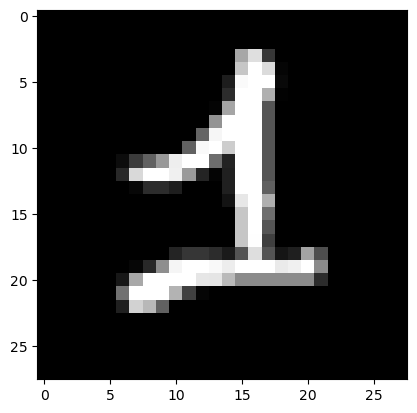

0


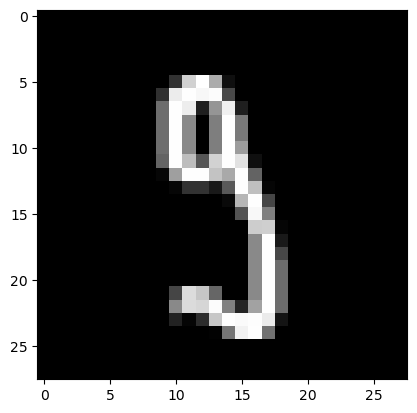

5


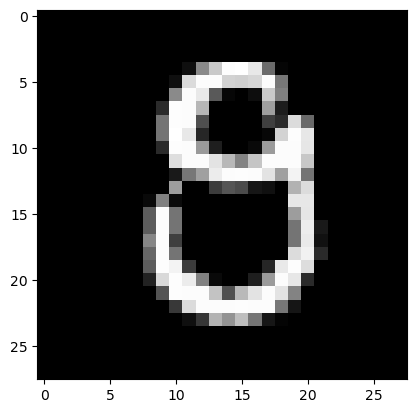

0


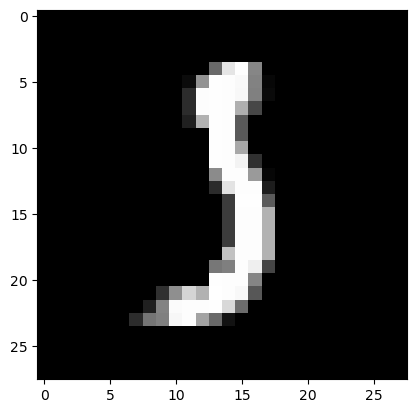

1


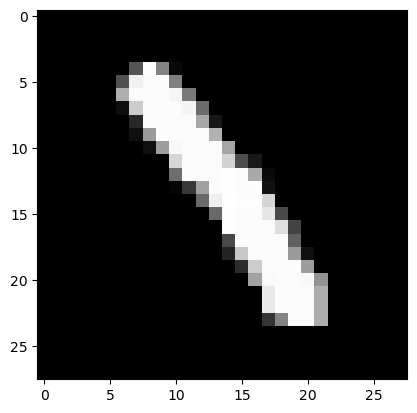

0


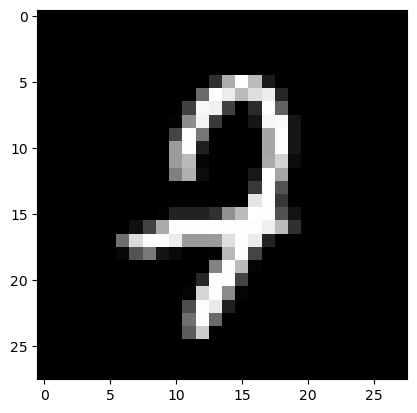

9


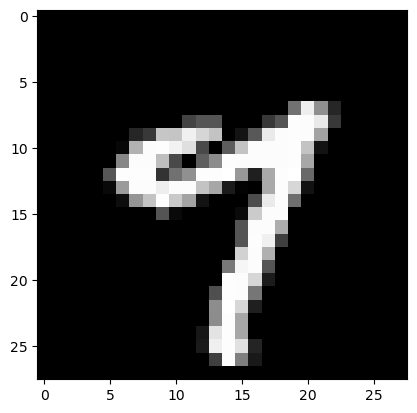

7


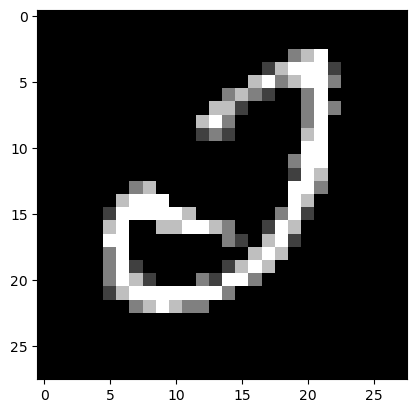

0


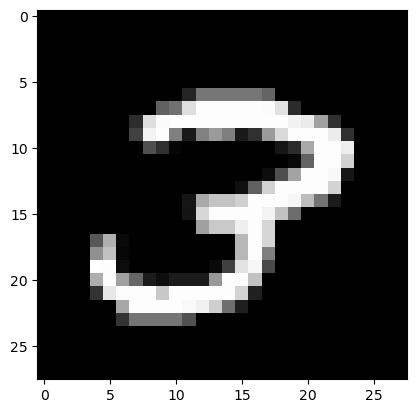

2


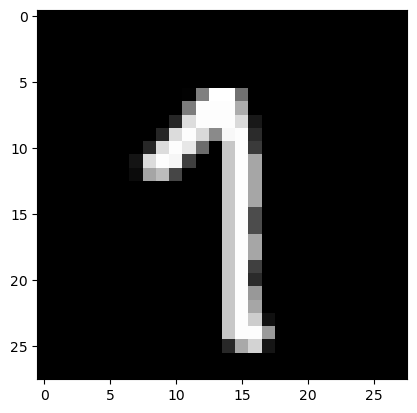

0


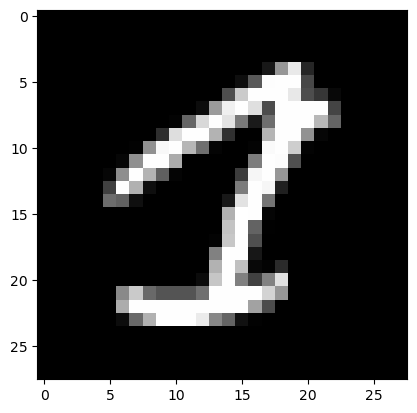

8


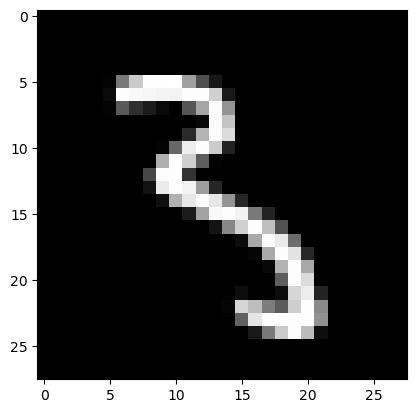

5


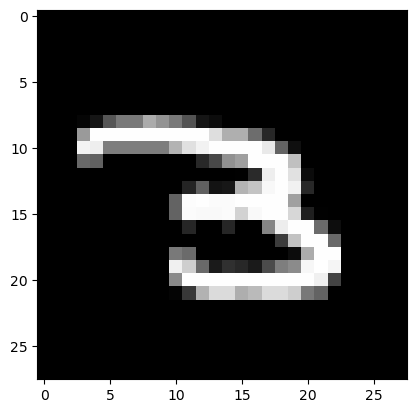

0


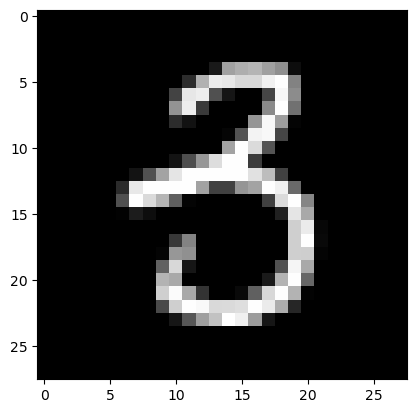

5


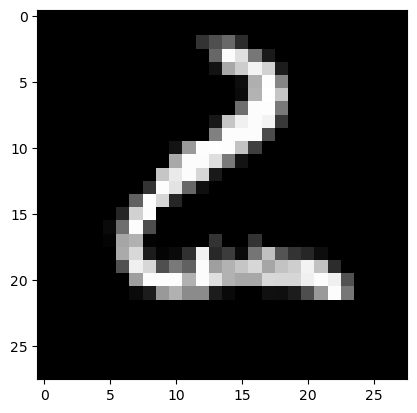

0


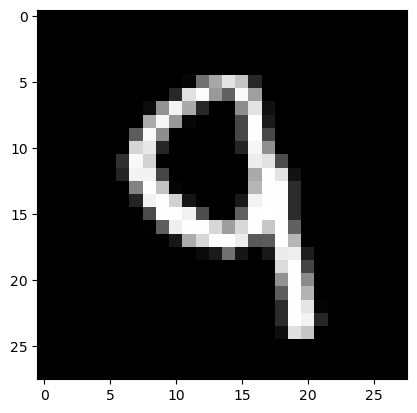

4


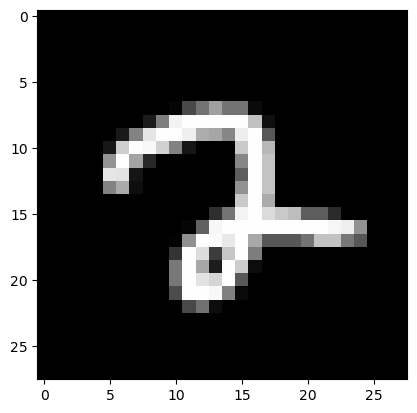

7


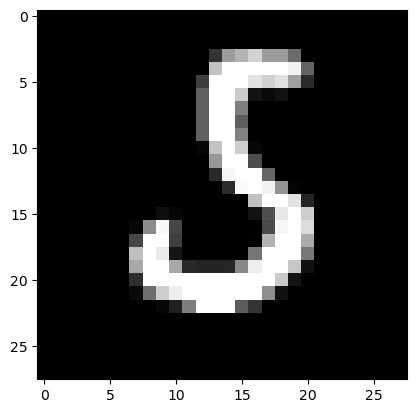

3


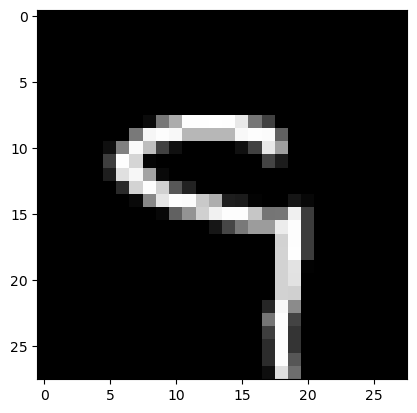

5


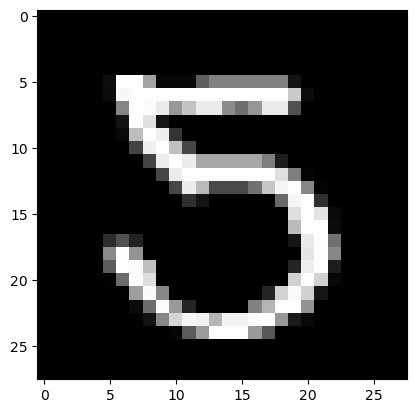

0


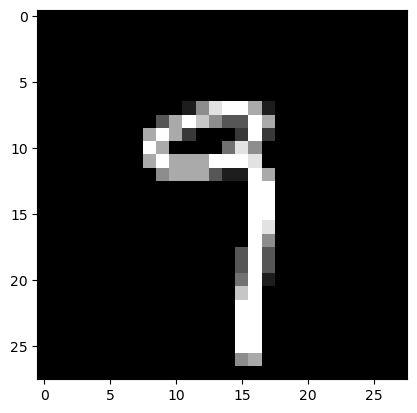

7


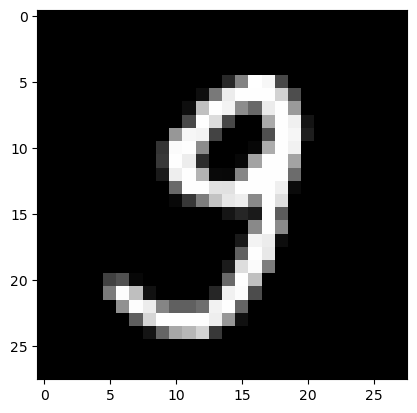

3


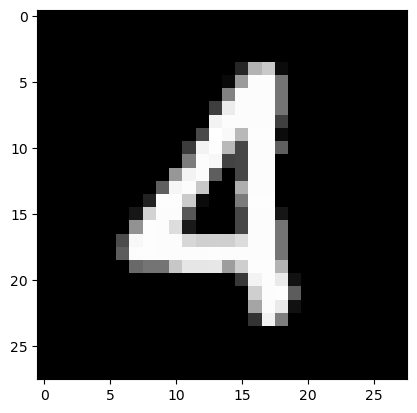

6


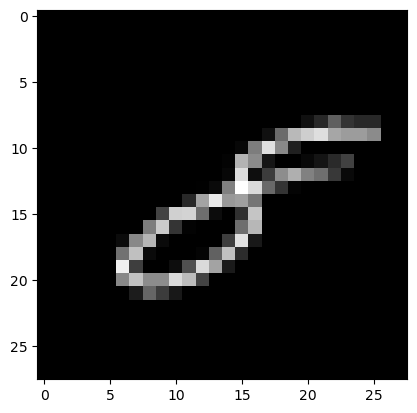

5


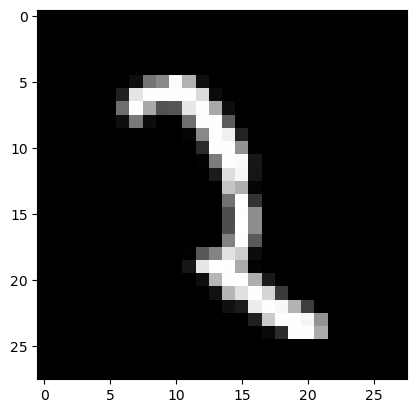

1


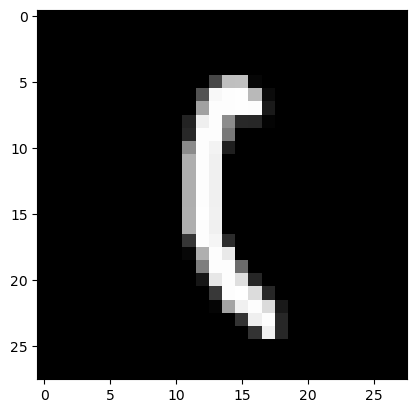

0


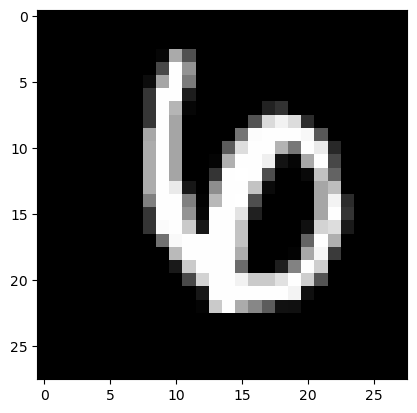

2


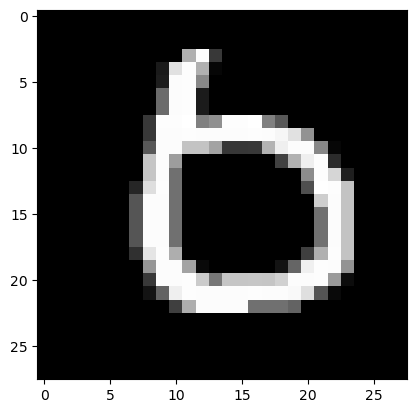

0


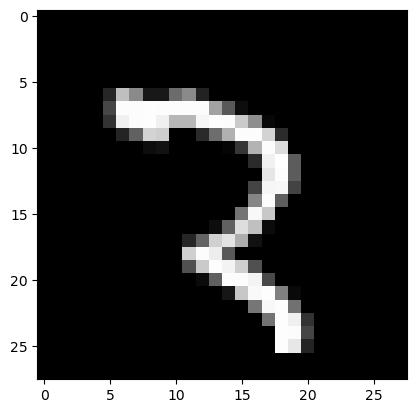

7


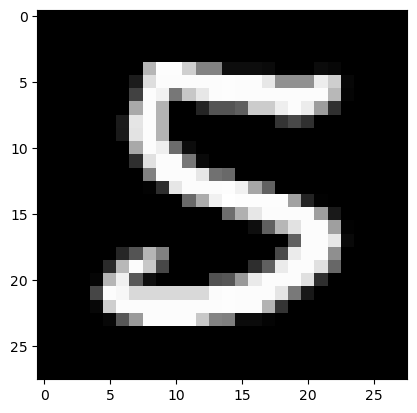

3


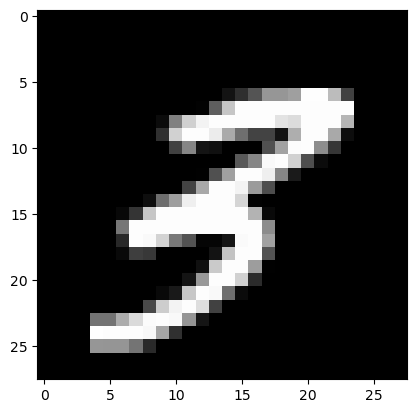

8


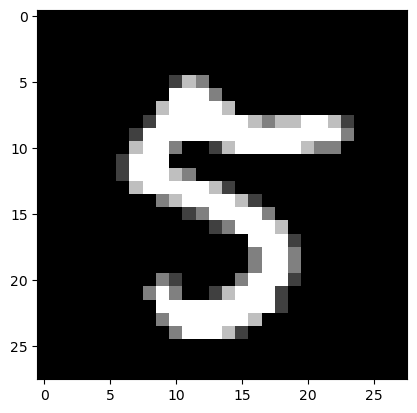

0


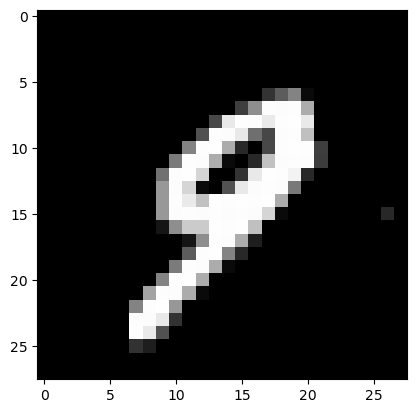

0


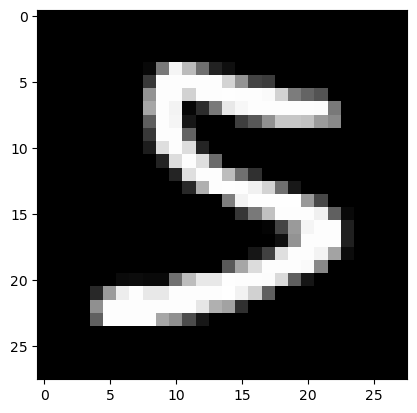

3


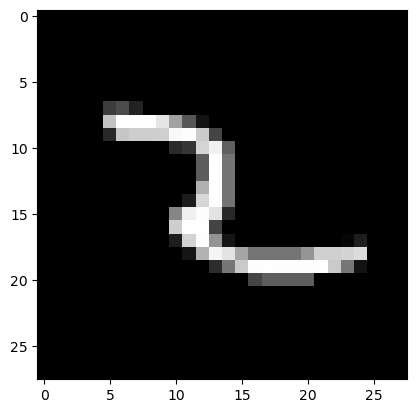

8


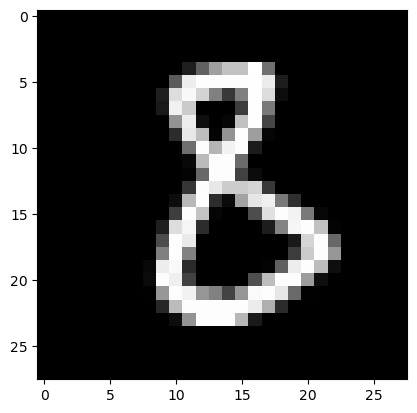

0


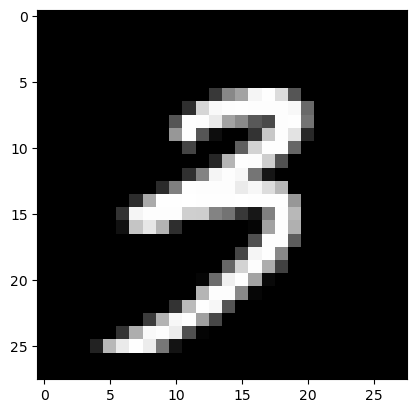

9


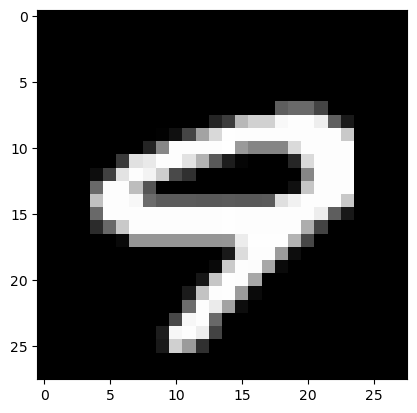

0


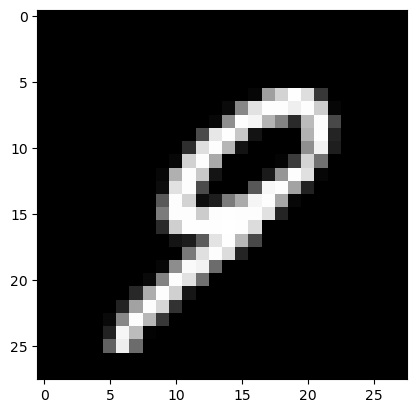

0


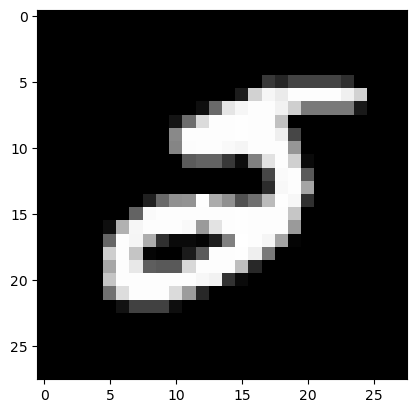

2


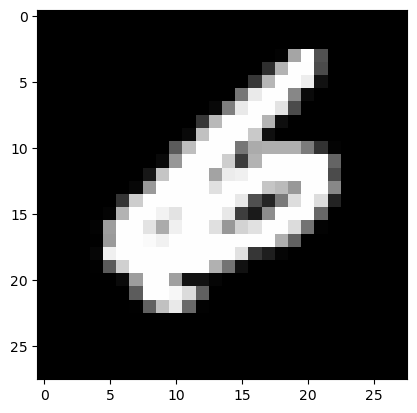

0


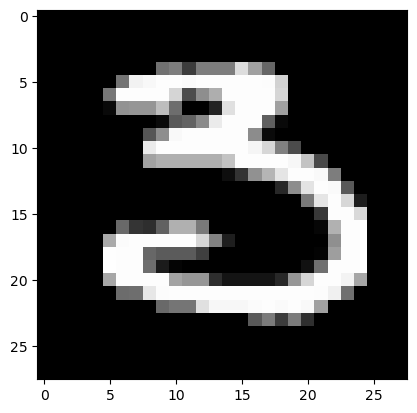

2


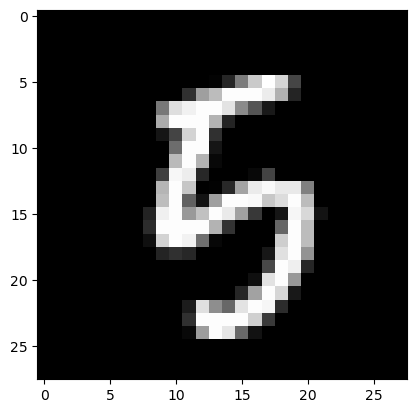

8


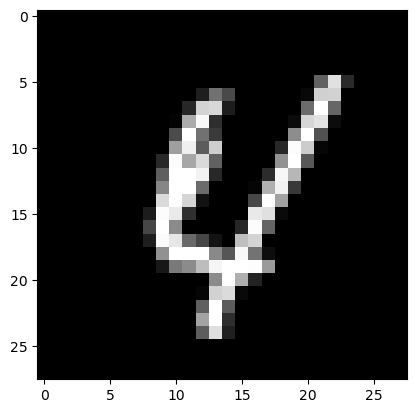

0


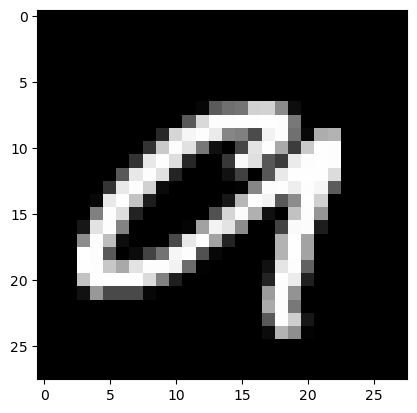

0


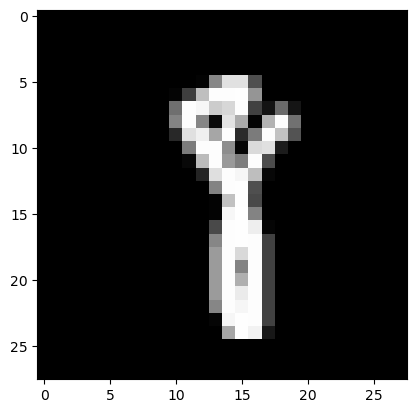

7


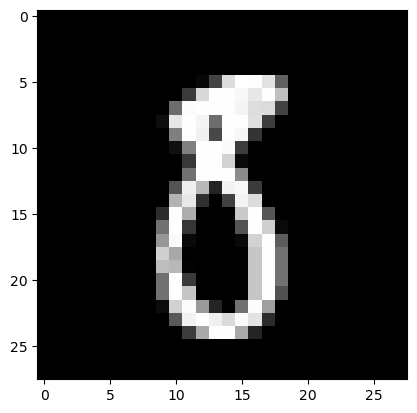

5


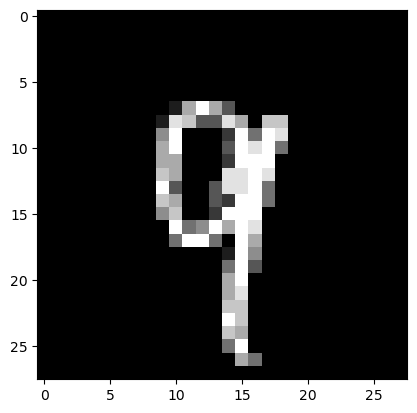

7


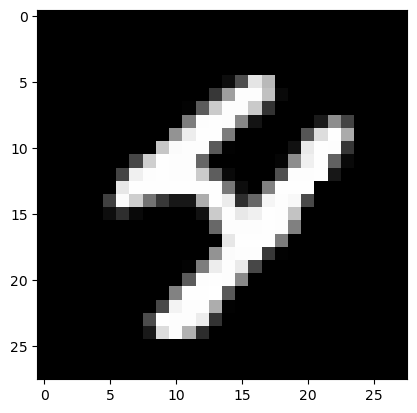

0


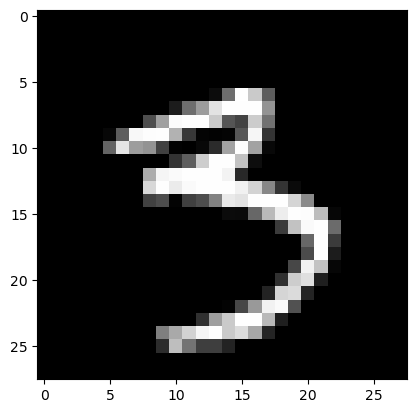

0


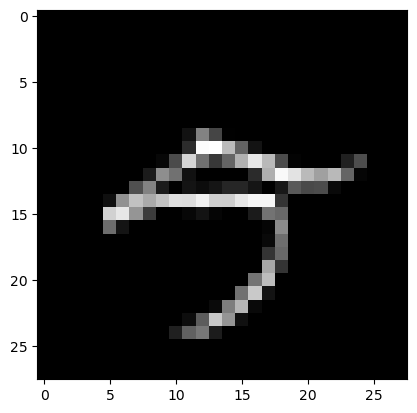

4


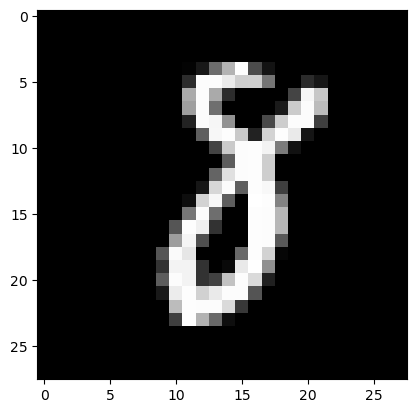

0


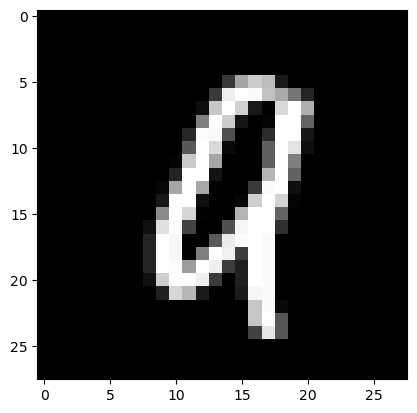

0


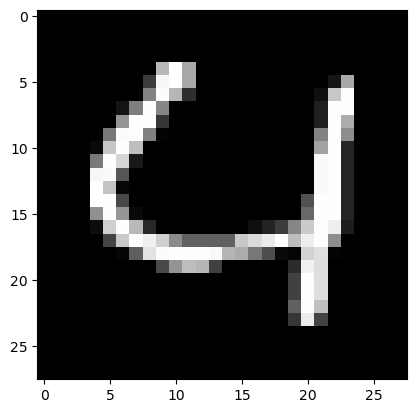

6


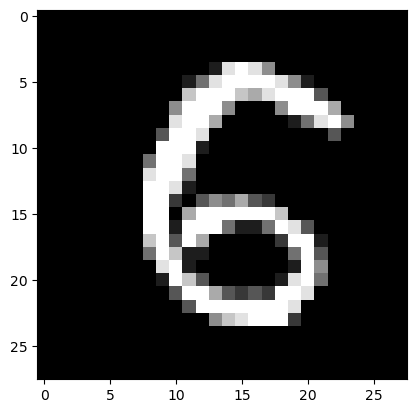

5


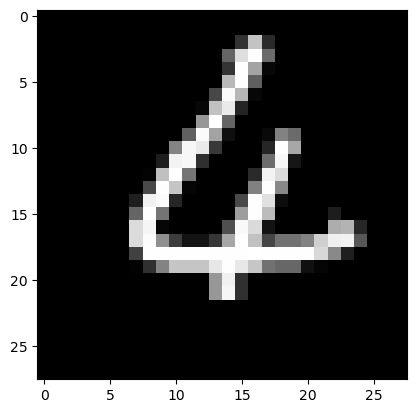

6


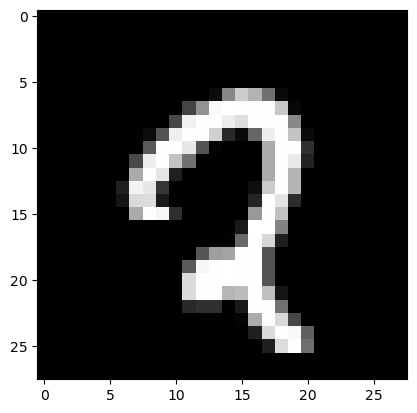

9


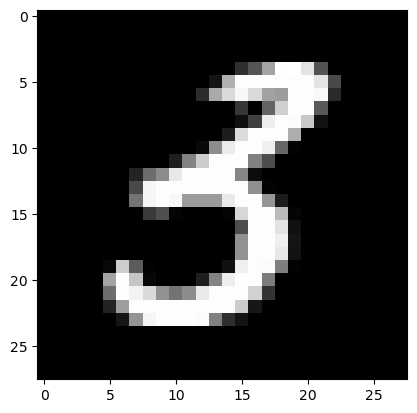

5


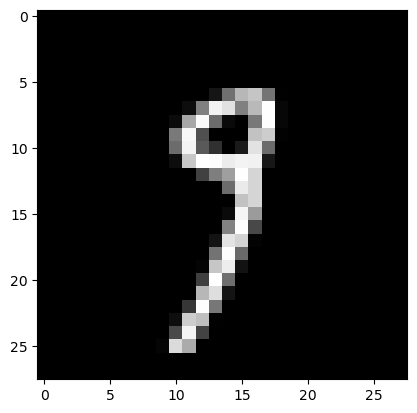

7


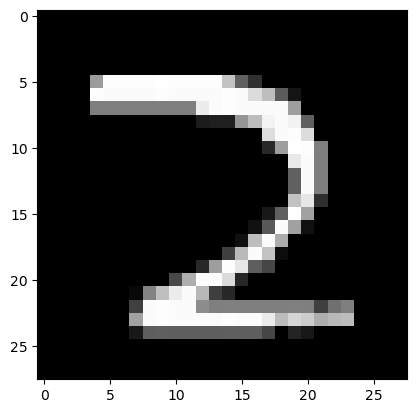

0


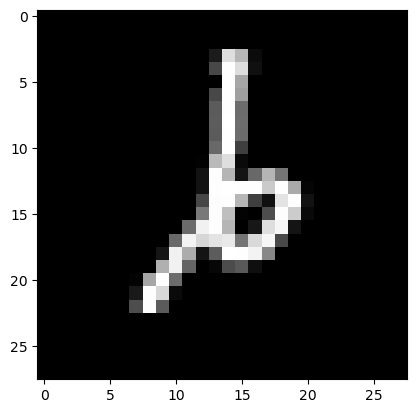

1


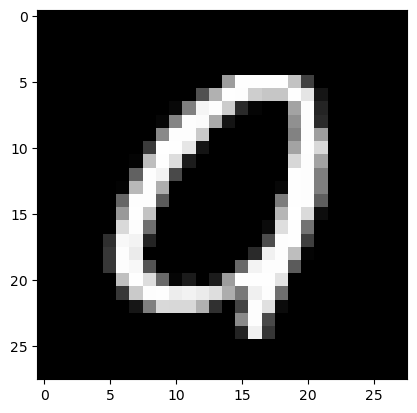

0


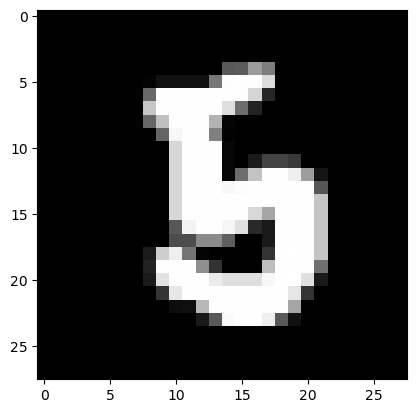

8


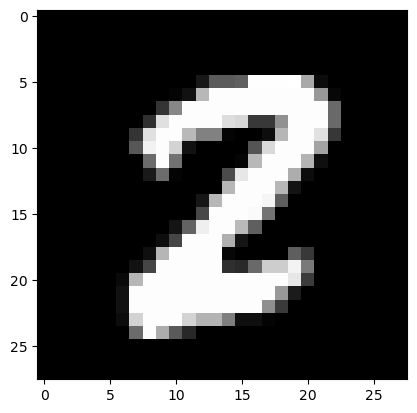

8


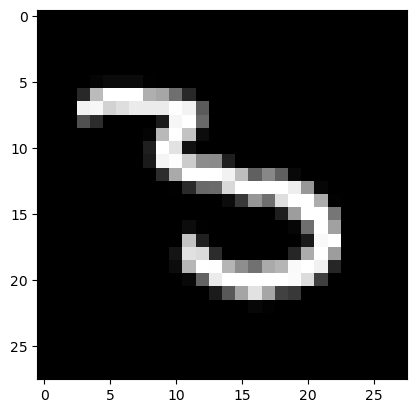

6


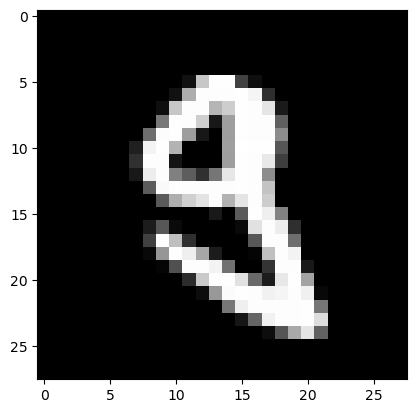

8


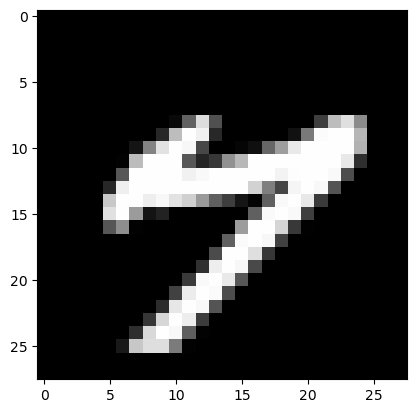

4


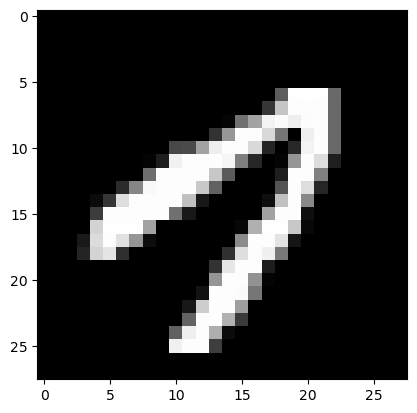

0


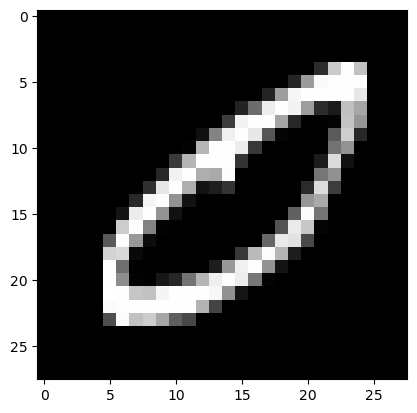

5


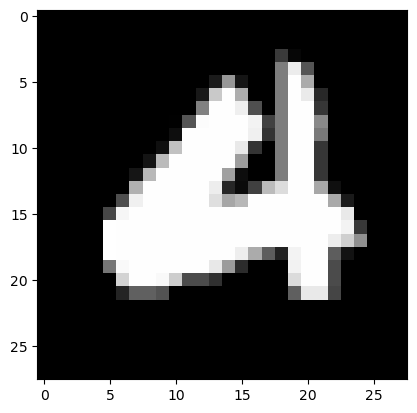

2


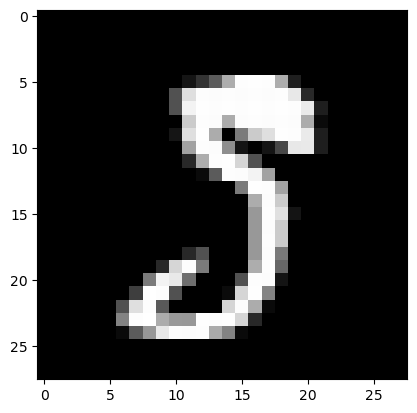

3


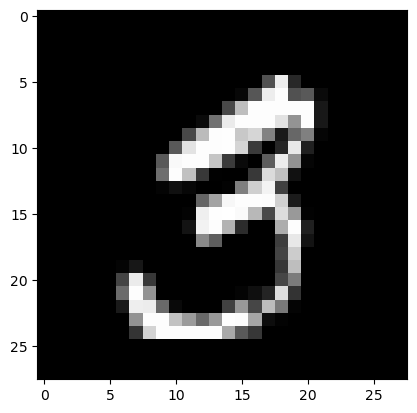

0


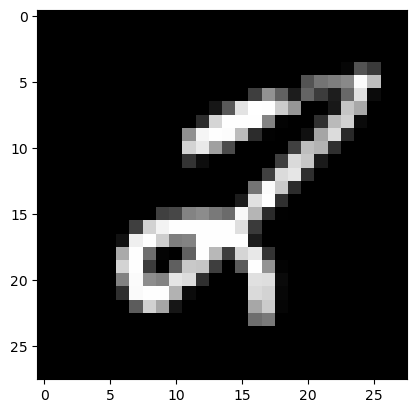

8


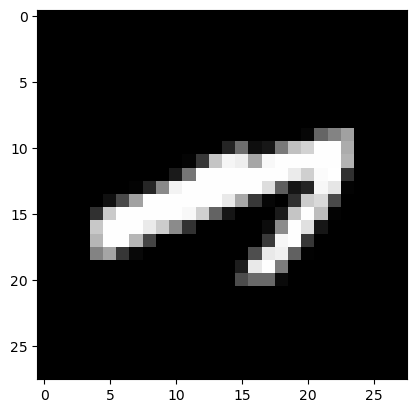

4


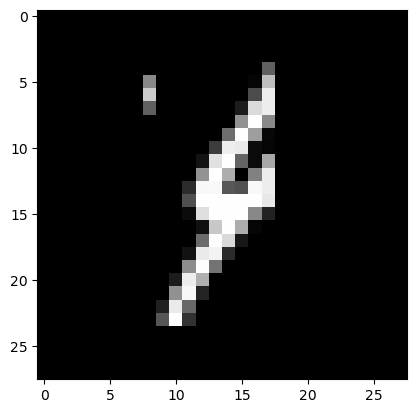

1


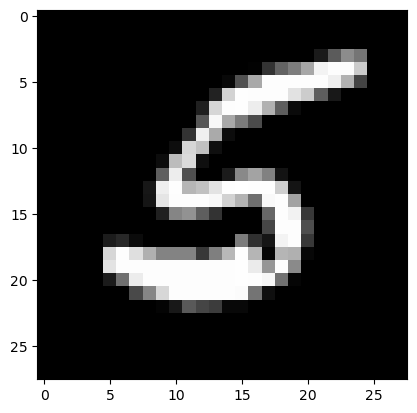

6


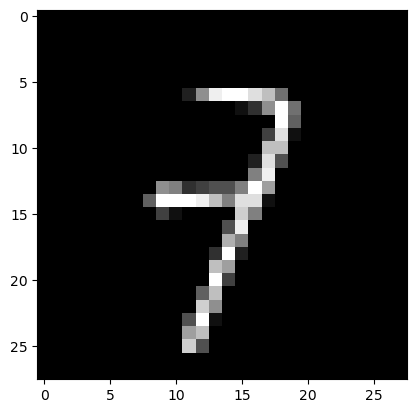

0


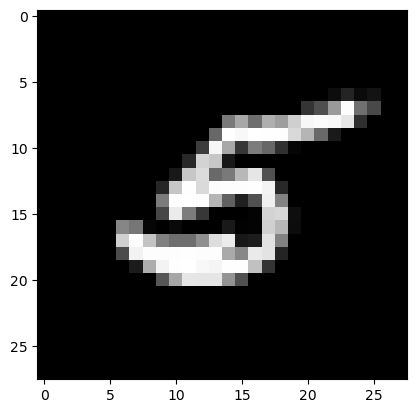

0


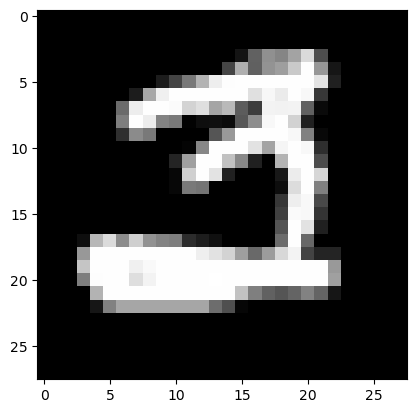

2


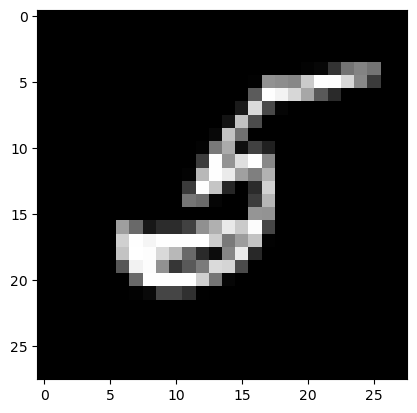

6


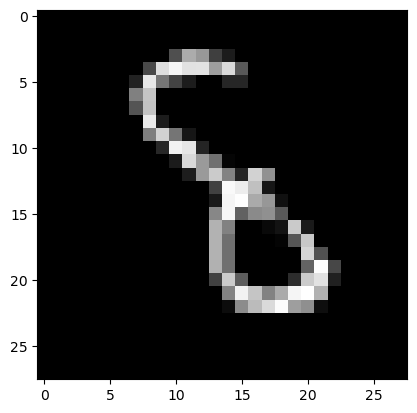

2


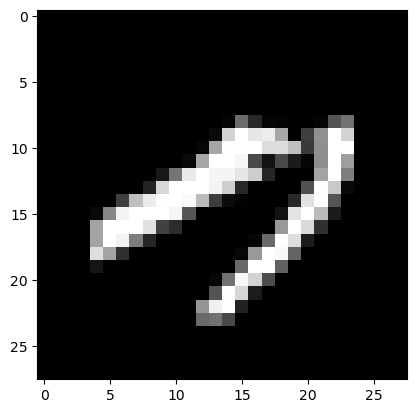

0


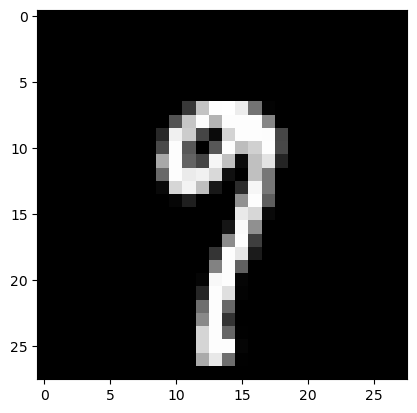

7


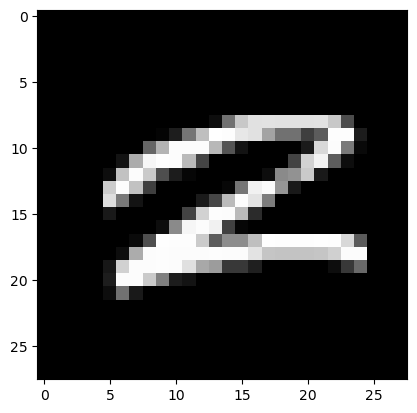

8


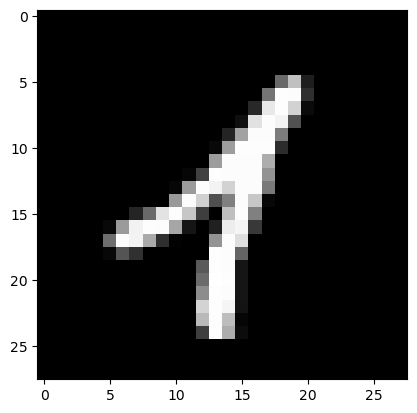

4


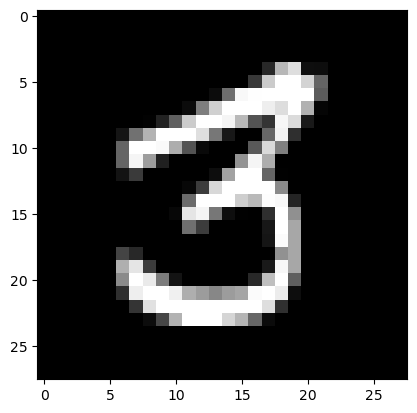

8


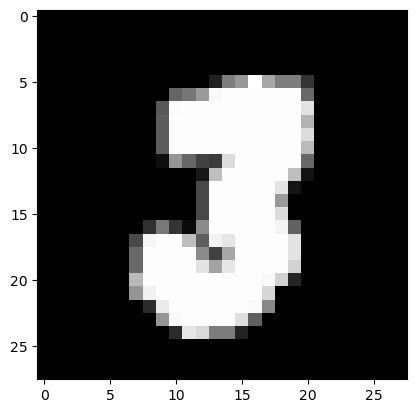

8


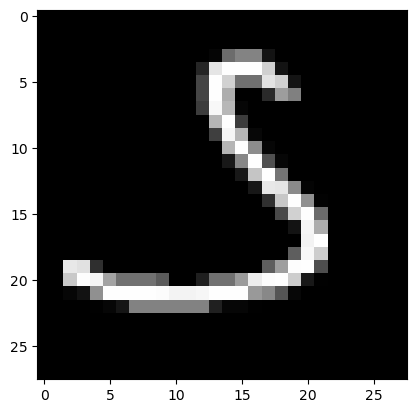

3


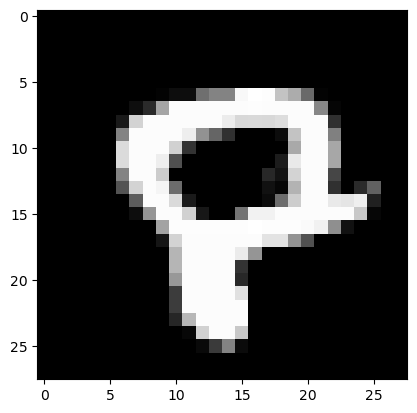

0


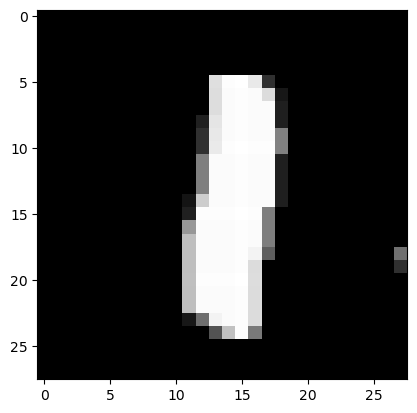

0


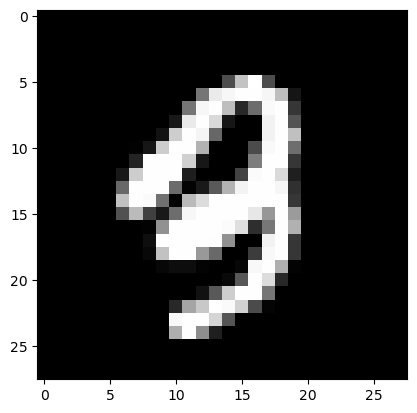

9


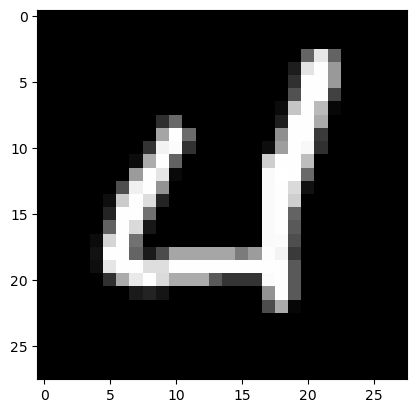

0


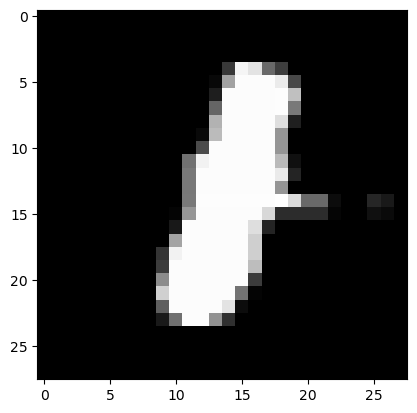

0


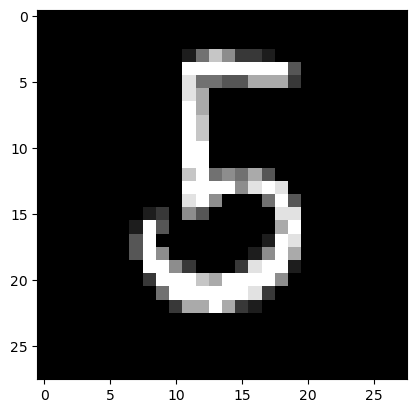

6


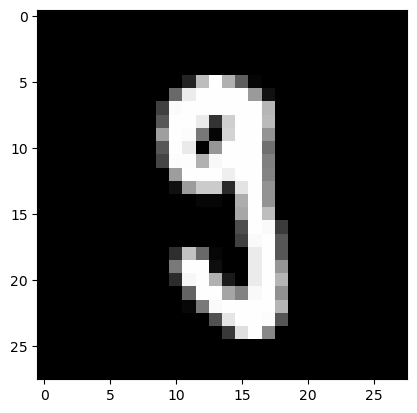

8


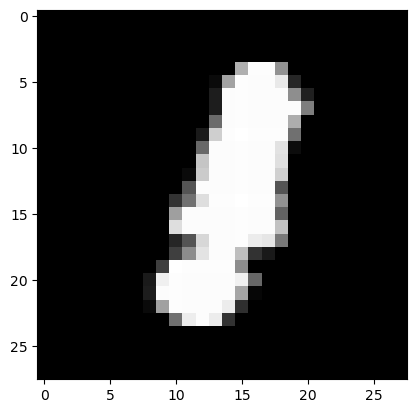

8


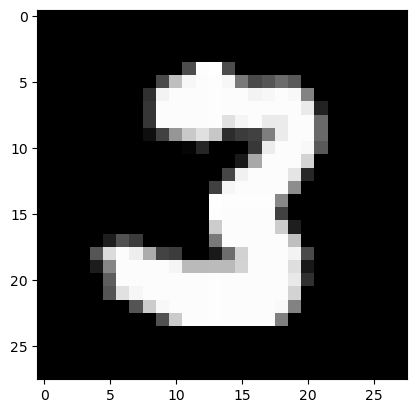

2


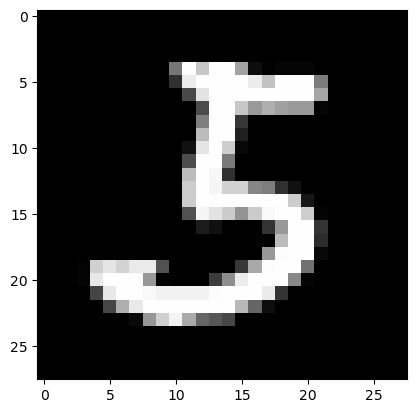

3


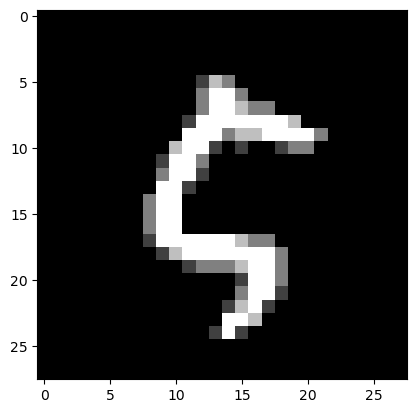

0


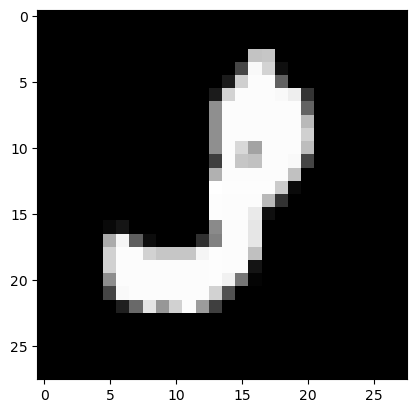

2


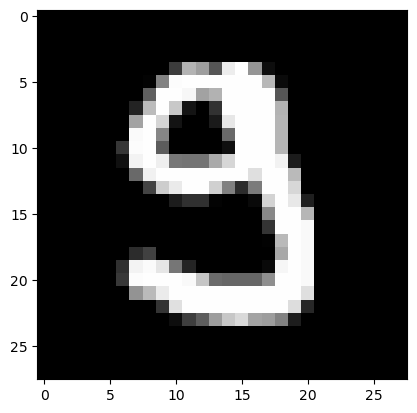

3


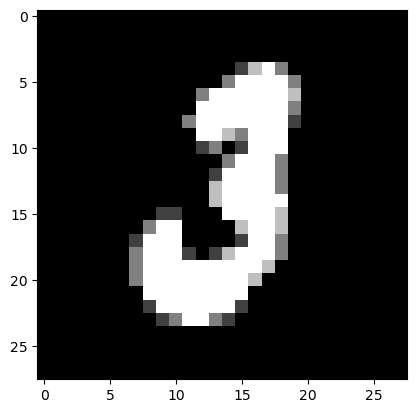

2


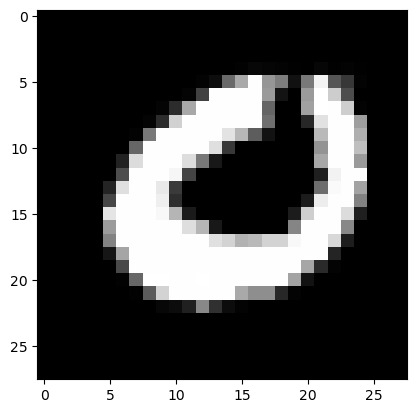

6


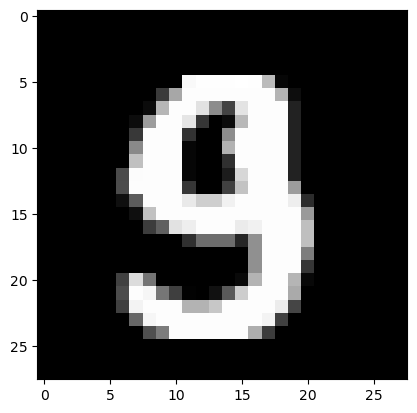

0


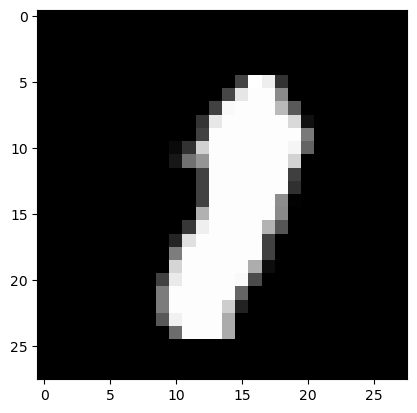

0


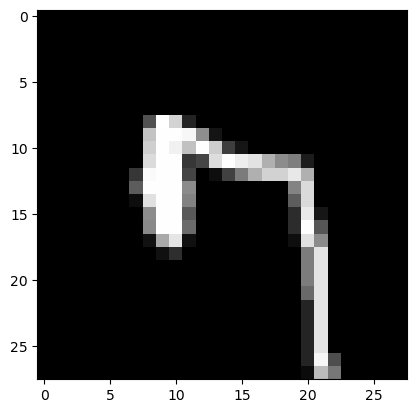

4


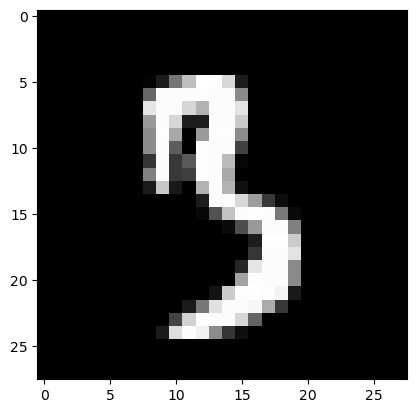

5


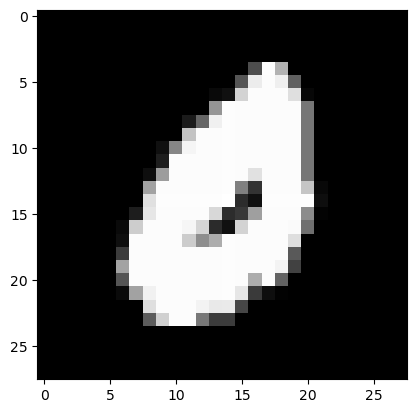

8


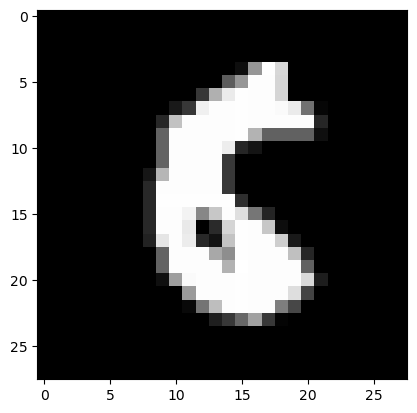

6


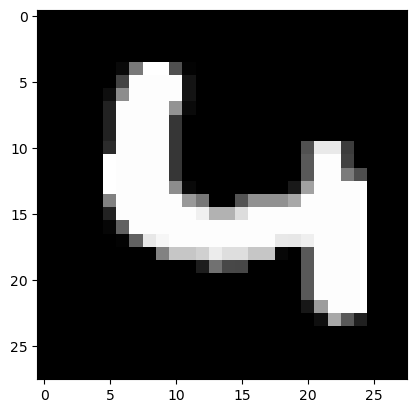

6


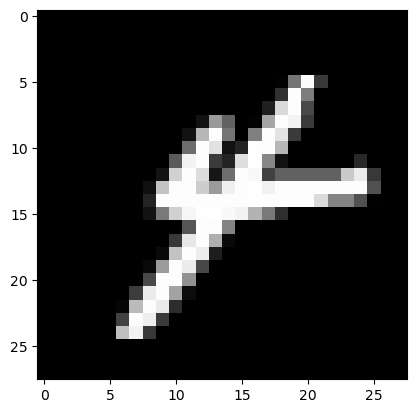

0


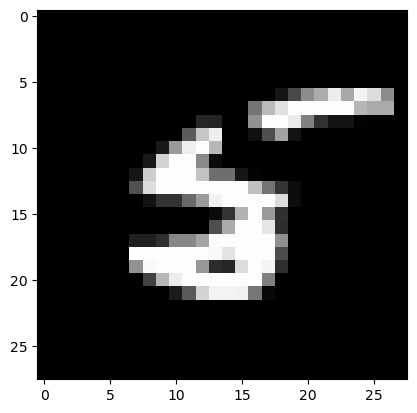

0


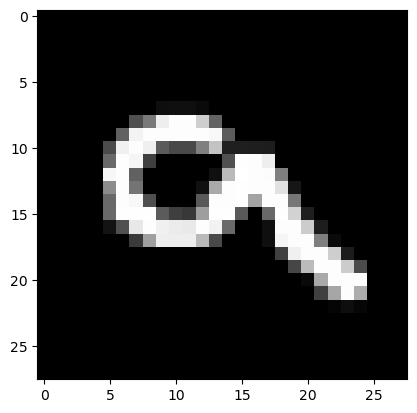

4


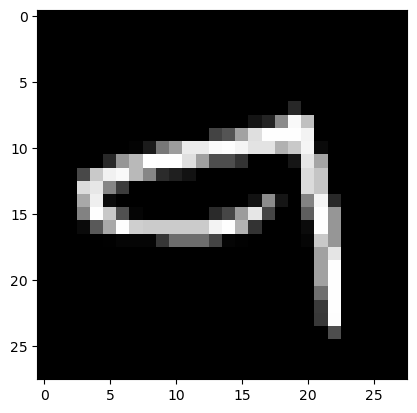

7


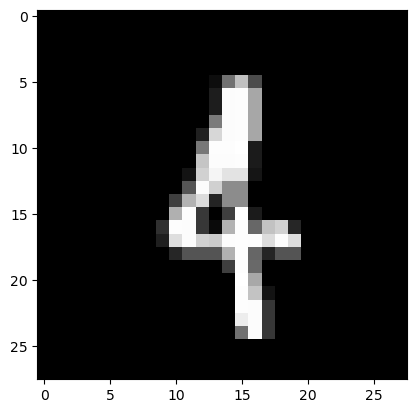

1


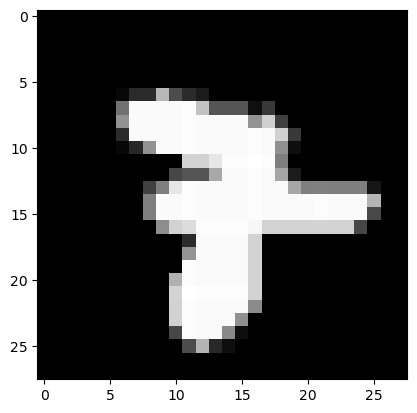

8


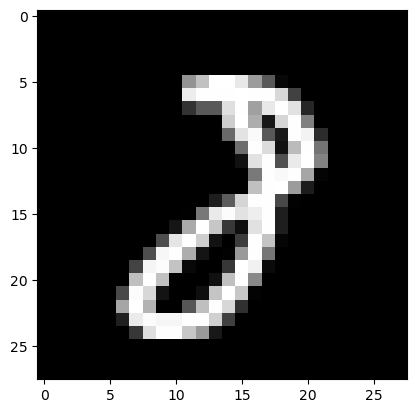

3


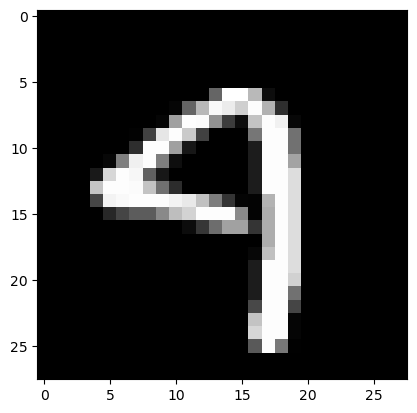

9


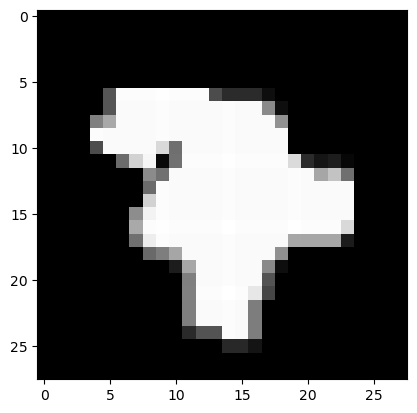

0


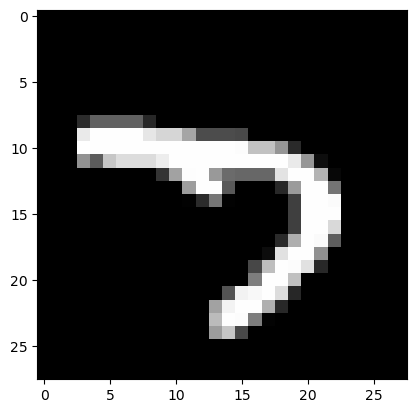

0


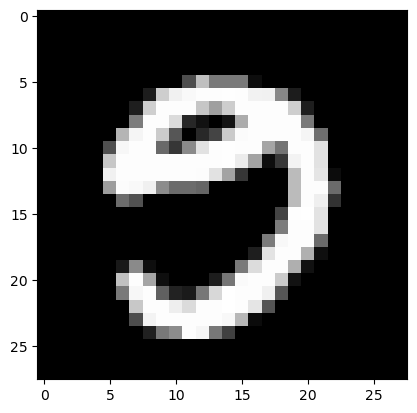

5


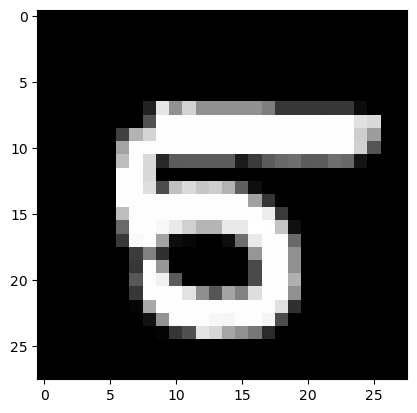

8


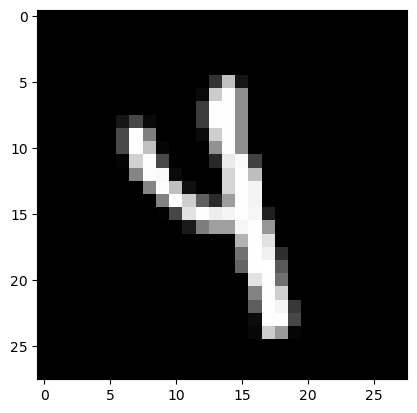

9


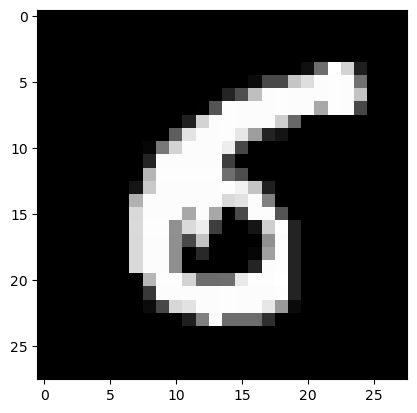

5


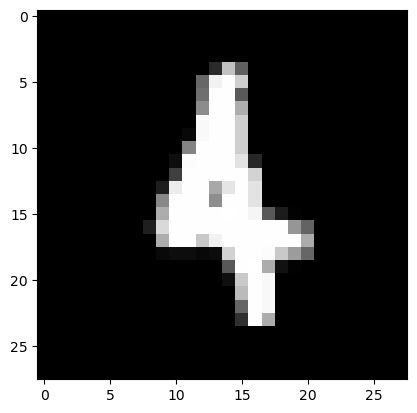

0


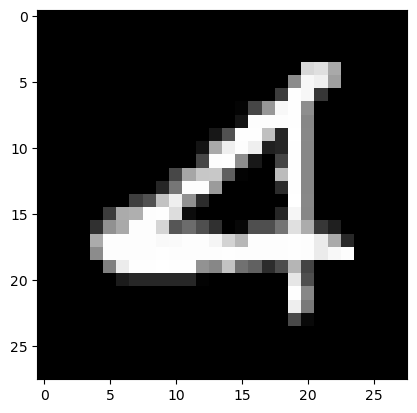

2


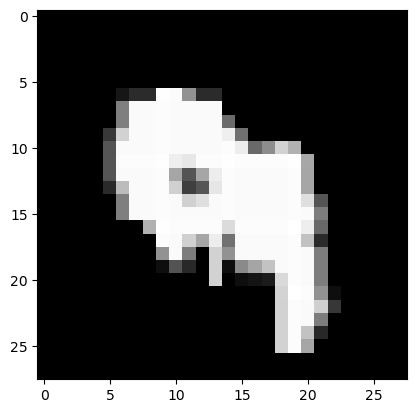

4


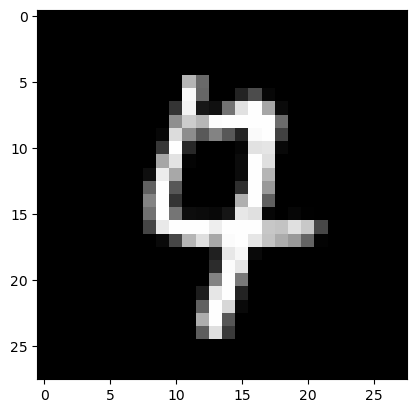

7


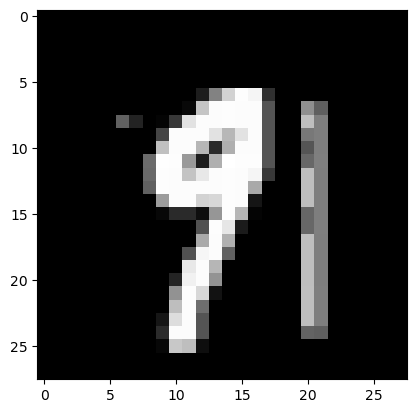

8


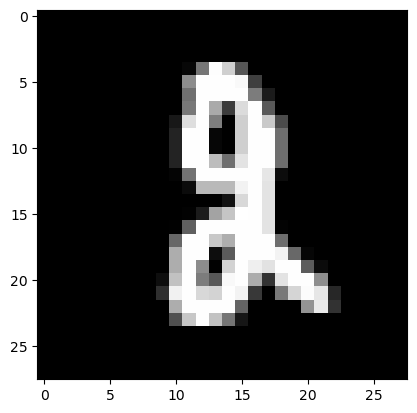

8


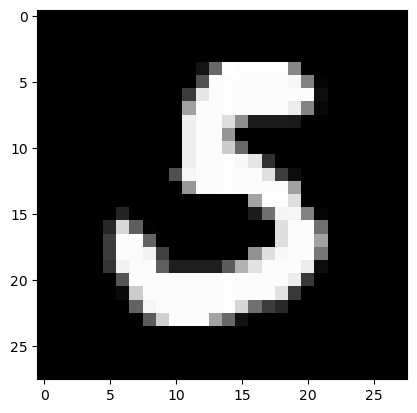

3


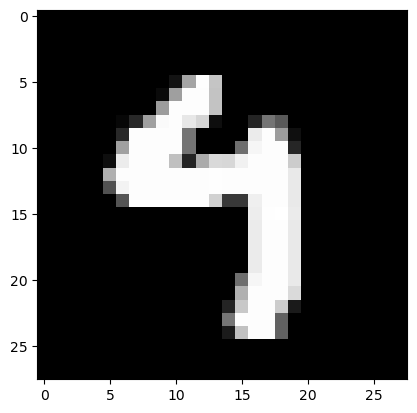

4


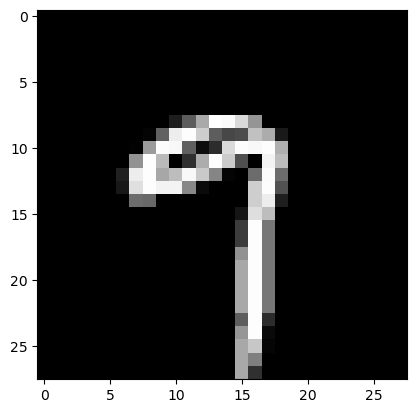

7


In [26]:
for i in range(len(a)):
    plt.imshow(x_test[a[i][0]].reshape(28,28) , cmap='gray')
    plt.show()
    print(a[i][1])

In [27]:
#live number detection use virtual OBS camera 

In [28]:
import cv2

In [24]:
b = []

In [31]:
try:
    del frame
    del ret
    del cap
except:
    None
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    frame = frame[20:230,65:260]
    abc = cv2.resize(frame , (28,28))
    grayFrame = -((cv2.cvtColor(abc, cv2.COLOR_BGR2GRAY)/255)-1).reshape((784))
    grayFrame = grayFrame* 0.97 #- np.mean(grayFrame)
    grayFrame[grayFrame<0.1] = 0
    b.append(grayFrame)
    
    frame = cv2.resize(frame , (500,500))
    if (grayFrame.sum() >=  25):
        pre = forward(data= grayFrame)
        text = (pre.argmax())
        text2= int((pre[0,text])*100)
        cv2.putText(frame, str(text2)+'%', (10,60),font ,0.80 , (0, 255, 255))
    else:text = 'none'
    
    cv2.putText(frame, str(text), (10,30),font ,1.15, (255, 0, 0))

    cv2.imshow('Input', frame)
    c = cv2.waitKey(1)
    if c == 27:
        break
cv2.destroyAllWindows()

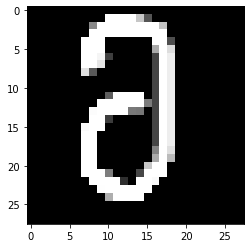

In [133]:
plt.imshow(b[-1000].reshape((28,28)), cmap='gray')

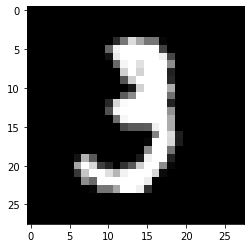

In [134]:
plt.imshow(x_test[10].reshape((28,28)), cmap='gray')

In [130]:
#save memory
a_file = open("data.pkl", "wb")
pickle.dump(mem, a_file)
a_file.close()

In [132]:
#load memory
a_file = open("data.pkl", "rb")
output = pickle.load(a_file)
a_file.close()